<a href="https://colab.research.google.com/github/mahtabkarami/Projects/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from IPython import get_ipython
from IPython.display import display
# %%

# STEP 1: Install required packages
!pip install tensorflow opencv-python-headless matplotlib

# STEP 2: Imports and paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from google.colab import files
from google.colab import drive # Import the drive module

# Mount Google Drive
drive.mount('/content/drive') # Mount Google Drive at /content/drive

# Set your paths here
image_dir = '/content/drive/MyDrive/archive/data/Blight' # Ensure this path is correct
mask_dir = '/content/drive/MyDrive/masks'
os.makedirs(mask_dir, exist_ok=True)

# STEP 3: Auto-generate masks using HSV thresholding
def generate_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blight = np.array([10, 40, 40])
    upper_blight = np.array([35, 255, 255])
    mask = cv2.inRange(hsv, lower_blight, upper_blight)
    mask = cv2.medianBlur(mask, 5)
    return mask

# ... (Rest of the code remains the same)

Mounted at /content/drive


✓ Masks generated and saved.
✓ Loaded 195 image-mask pairs.
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6985 - loss: 0.5964 - val_accuracy: 0.8244 - val_loss: 0.4279
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.7927 - loss: 0.4210 - val_accuracy: 0.8900 - val_loss: 0.2124
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 0.8882 - loss: 0.2522 - val_accuracy: 0.9462 - val_loss: 0.1267
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.9184 - loss: 0.1791 - val_accuracy: 0.9557 - val_loss: 0.1024
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9317 - loss: 0.1434 - val_accuracy: 0.9625 - val_loss: 0.0786
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.9502 - loss: 0.0981 - val_accuracy: 0.9530 - val_loss: 0.0973
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9452 - loss: 0.1141 - val_accuracy: 0.9708 - val_loss: 0.0611
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 2

✓ Model trained and saved as blight_segmentation_unet.h5


Saving Corn_Blight (89).jpg to Corn_Blight (89).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


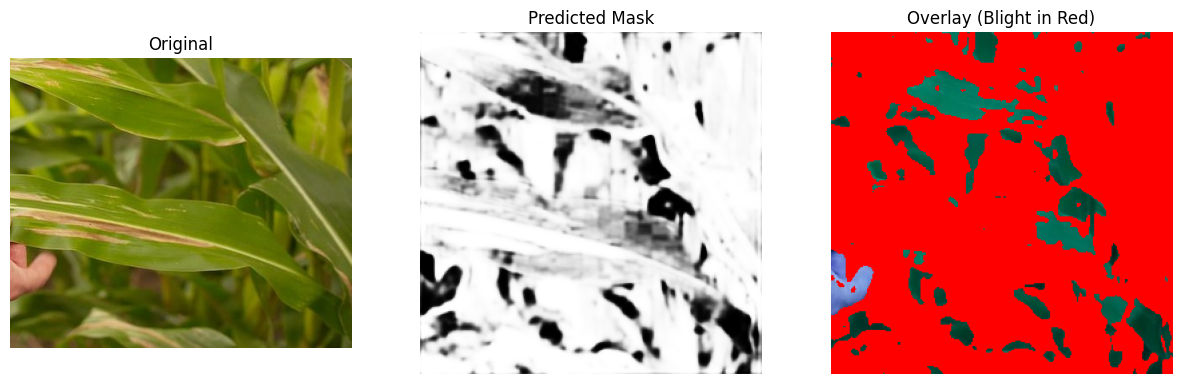

In [2]:
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            mask = generate_mask(img)
            mask_filename = filename.rsplit('.', 1)[0] + '_mask.png'
            cv2.imwrite(os.path.join(mask_dir, mask_filename), mask)

print("✓ Masks generated and saved.")

# STEP 4: Load image-mask pairs
def load_data(img_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    for filename in os.listdir(img_dir):
        if not filename.endswith(('.jpg', '.jpeg', '.png')): continue
        img_path = os.path.join(img_dir, filename)
        mask_path = os.path.join(mask_dir, filename.rsplit('.', 1)[0] + '_mask.png')
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is not None and mask is not None:
            img = cv2.resize(img, img_size) / 255.0
            mask = cv2.resize(mask, img_size) / 255.0
            mask = np.expand_dims(mask, axis=-1)
            images.append(img)
            masks.append(mask)
    return np.array(images), np.array(masks)

X, Y = load_data(image_dir, mask_dir)
print(f"✓ Loaded {len(X)} image-mask pairs.")

# STEP 5: Build U-Net model
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b1 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(256, 3, activation='relu', padding='same')(b1)

    # Decoder
    u2 = layers.UpSampling2D()(b1)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    u3 = layers.UpSampling2D()(c3)
    u3 = layers.concatenate([u3, c1])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)
    return Model(inputs, outputs)

# STEP 6: Compile and train
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, Y, batch_size=8, epochs=20, validation_split=0.2)

# Save the trained model
model.save('blight_segmentation_unet.h5')
print("✓ Model trained and saved as blight_segmentation_unet.h5")

# STEP 7: Upload and predict new images
def predict_and_show(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (256, 256)) / 255.0
    input_img = np.expand_dims(img_resized, axis=0)

    pred_mask = model.predict(input_img)[0, :, :, 0]

    # Threshold for binary mask
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255

    # Overlay on original image
    overlay = img_resized.copy()
    overlay[pred_mask > 0.5] = [1.0, 0, 0]  # red where blight is detected

    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay (Blight in Red)")
    plt.axis('off')
    plt.show()

# Upload and test
uploaded = files.upload()
for filename in uploaded.keys():
    predict_and_show(filename)

In [3]:

# STEP X: Define Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [4]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coefficient])

In [5]:

def dice_score_np(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def predict_and_show(image_path, true_mask_path=None):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (256, 256)) / 255.0
    input_img = np.expand_dims(img_resized, axis=0)

    # Predict mask
    pred_mask = model.predict(input_img)[0, :, :, 0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    # If ground truth mask is provided, compute Dice
    if true_mask_path:
        true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
        true_mask = cv2.resize(true_mask, (256, 256)) / 255.0
        true_mask_bin = (true_mask > 0.5).astype(np.uint8)
        dice = dice_score_np(true_mask_bin, pred_mask_bin)
        print(f"Dice Coefficient (Pred vs Ground Truth): {dice:.4f}")
    else:
        dice = None

    # Overlay
    overlay = img_resized.copy()
    overlay[pred_mask > 0.5] = [1.0, 0, 0]

    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    title = f"Blight Overlay"
    if dice is not None:
        title += f"\nDice: {dice:.4f}"
    plt.title(title)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Dice Coefficient (Pred vs Ground Truth): 0.6942


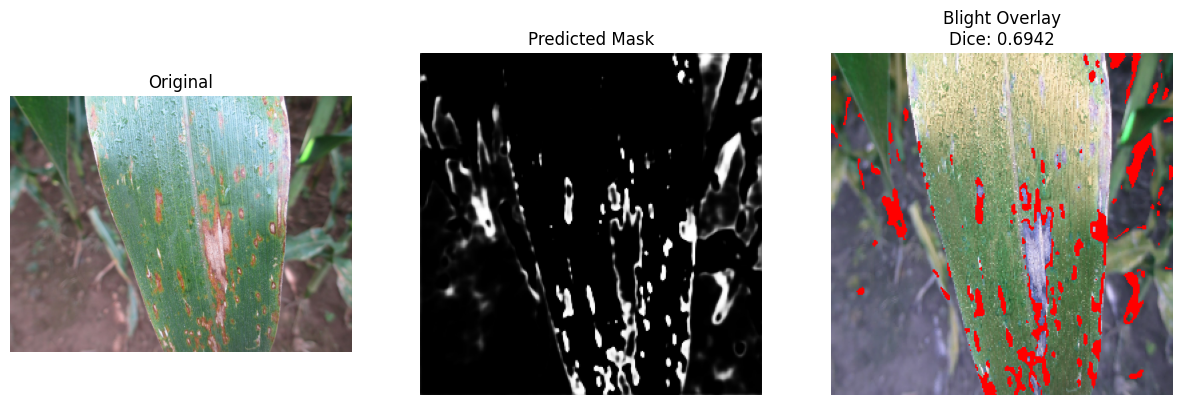

In [6]:
predict_and_show("/content/drive/MyDrive/archive/data/Blight/Corn_Blight (21).jpg", "/content/drive/MyDrive/masks/Corn_Blight (21)_mask.png")

In [7]:

import pandas as pd

def compare_masks_folder(image_folder, mask_folder, model, img_size=(256, 256)):
    results = []

    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        image_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename.rsplit('.', 1)[0] + '_mask.png')
        if not os.path.exists(mask_path):
            print(f"Skipping {filename} — no corresponding mask found.")
            continue

        # Load and preprocess
        img = cv2.imread(image_path)
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or true_mask is None:
            print(f"Error loading {filename}, skipping.")
            continue

        img_resized = cv2.resize(img, img_size) / 255.0
        true_mask = cv2.resize(true_mask, img_size) / 255.0
        true_mask_bin = (true_mask > 0.5).astype(np.uint8)

        pred_mask = model.predict(np.expand_dims(img_resized, axis=0))[0, :, :, 0]
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        # Calculate Dice
        dice = dice_score_np(true_mask_bin, pred_mask_bin)
        results.append({'Image': filename, 'Dice Coefficient': round(dice, 4)})

    df = pd.DataFrame(results)
    print(df)
    return df

In [ ]:

image_folder = '/content/drive/MyDrive/archive/data/Blight'
mask_folder = '/content/drive/MyDrive/masks'
dice_table = compare_masks_folder(image_folder, mask_folder, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [12]:

print(os.listdir(image_folder))
print(os.listdir(mask_folder))

['Blight', 'Healthy', 'Common_Rust', 'Gray_Leaf_Spot']
['Corn_Blight (1071) (1)_mask.png', 'Corn_Blight (847)_mask.png', 'Corn_Blight (1044)_mask.png', 'Corn_Blight (656)_mask.png', 'Corn_Blight (147)_mask.png', 'Corn_Blight (906)_mask.png', 'Corn_Blight (934)_mask.png', 'Corn_Blight (589)_mask.png', 'Corn_Blight (664)_mask.png', 'Corn_Blight (872)_mask.png', 'Corn_Blight (183)_mask.png', 'Corn_Blight (666)_mask.png', 'Corn_Blight (197)_mask.png', 'Corn_Blight (212)_mask.png', 'Corn_Blight (723)_mask.png', 'Corn_Blight (821)_mask.png', 'Corn_Blight (559)_mask.png', 'Corn_Blight (341)_mask.png', 'Corn_Blight (799)_mask.png', 'Corn_Blight (381)_mask.png', 'Corn_Blight (119)_mask.png', 'Corn_Blight (522)_mask.png', 'Corn_Blight (492)_mask.png', 'Corn_Blight (1019)_mask.png', 'Corn_Blight (336)_mask.png', 'Corn_Blight (277)_mask.png', 'Corn_Blight (728)_mask.png', 'Corn_Blight (436)_mask.png', 'Corn_Blight (533)_mask.png', 'Corn_Blight (1114)_mask.png', 'Corn_Blight (891)_mask.png', 'Corn_

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt

def show_color_coded_table(df):
    # Style: color code by Dice Coefficient
    styled_df = df.style.background_gradient(
        subset=['Dice Coefficient'], cmap='YlGn', vmin=0, vmax=1
    ).set_caption("Dice Coefficient Comparison by Image")

    display(styled_df)
show_color_coded_table(dice_table)

,Image,Dice Coefficient
0,Corn_Blight (1071).JPG,0.959800
1,Corn_Blight (847).JPG,0.971000
2,Corn_Blight (1044).JPG,0.939800
3,Corn_Blight (656).JPG,0.958500
4,Corn_Blight (147).jpg,0.975900
5,Corn_Blight (906).jpg,0.975400
6,Corn_Blight (934).JPG,0.966300
7,Corn_Blight (589).JPG,0.968900
8,Corn_Blight (664).JPG,0.956000
9,Corn_Blight (872).JPG,0.984700


<ipython-input-15-cbef49f2f4ca>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Image', y='Dice Coefficient', data=dice_table, palette='viridis')


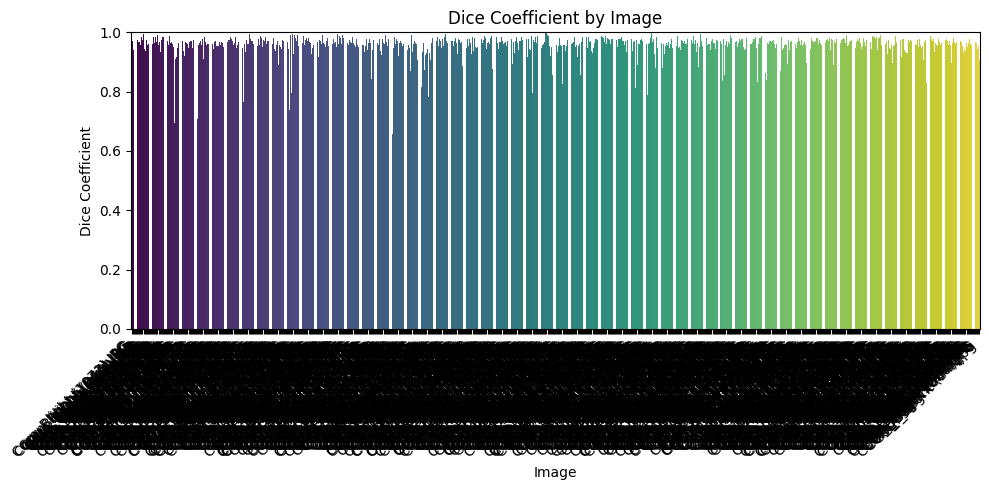

In [15]:

plt.figure(figsize=(10, 5))
sns.barplot(x='Image', y='Dice Coefficient', data=dice_table, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Dice Coefficient by Image")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()